Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/CS263_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/CS263_Project


Loading all datasets from drive

In [0]:
import pandas as pd
df = pd.read_csv(r"all_data.csv")
test_set = pd.read_csv(r"test_set.csv")
sentiment_data = pd.read_csv(r"sentiment.csv")

In [3]:
!pip install torch
!pip install transformers

     |████████████████████████████████| 675kB 3.3MB/s 
     |████████████████████████████████| 1.1MB 8.8MB/s 
     |████████████████████████████████| 890kB 15.6MB/s 
     |████████████████████████████████| 3.8MB 22.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=2ac71177476bee33855145706f24777ef45839c1b77f93ead03191e636764590
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Function for BERT Vectorization is defined

In [0]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


def vectorizeBERT(df, bert_type = "bert"):

  if bert_type == "distil":
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
  elif bert_type == "roberta":
    model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')
  else:
    model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

  # Load pretrained model/tokenizer
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights)

  tokenized = df["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  # padding step
  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
      max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)
  attention_mask.shape

  input_ids = torch.tensor(np.array(padded))
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
  # Slice the output for the first position for all the sequences, take all hidden unit outputs
  features = last_hidden_states[0][:,0,:].numpy()

  return features



Function for obtaining sentiment score using sentiment data is defined

In [0]:
import random
import pickle
def obtain_sentiment_classifier(sentiment_data,data_select=4000,bert_type="bert"):

  #Randomly selecting a small portion of sentiment data, since the dataset is too big
  rand_ind = random.sample(range(sentiment_data.shape[0]),data_select)
  sentiment=sentiment_data.iloc[rand_ind]
  # Build the sentiment model
  features = vectorizeBERT(sentiment,bert_type=bert_type)
  features_ds = pd.DataFrame(features)
  labels = sentiment["label"]
  train_features, test_features, train_labels, test_labels = train_test_split(features_ds, labels)
  #Logistic Regression classifier for sentiment analysis
  lr_clf_sentiment = LogisticRegression(max_iter=5000)
  lr_clf_sentiment.fit(train_features, train_labels)
  #Calculate score of logistic regression classifier on sentiment data
  sent_accuracy = lr_clf_sentiment.score(test_features, test_labels)
  print("The accuracy of Logistic Regression classifier on sentiment data is: ",sent_accuracy)
  pickle.dump(lr_clf_sentiment, open("sentiment_model_distil", 'wb'))
  return lr_clf_sentiment

In [25]:
# Build the cognitive distortion model
# M x N matrix
import time
start_time = time.time()
features = vectorizeBERT(df,bert_type="distil")
print("Time taken is:",time.time()-start_time)

Time taken is: 91.20670056343079


Creating training dataset with features and sentiment scores

In [18]:
labels = df["label"]
features_df = pd.DataFrame(features)
lr_clf_sentiment = obtain_sentiment_classifier(sentiment_data,data_select=4000,bert_type="distil")
#lr_clf_sentiment = pickle.load(open("sentiment_model_distil","rb"))
sentiment_score = lr_clf_sentiment.predict_log_proba(features)[:,0]
features_df["sentiment_score"] = sentiment_score
features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,sentiment_score
0,-0.087593,-0.014889,-0.047897,-0.194918,-0.207854,-0.149689,0.489435,0.592164,-0.200689,-0.340896,-0.043105,-0.357107,-0.368491,0.486405,0.120391,0.265987,-0.057229,0.173425,0.030791,-0.002168,0.162766,-0.071762,0.113593,-0.003992,0.145600,-0.006519,-0.068760,-0.180929,-0.042907,0.015845,-0.120545,0.224573,-0.039434,-0.022718,-0.027674,-0.125107,-0.223559,-0.179898,-0.010274,0.099481,...,-0.188875,-0.191360,0.430189,-0.233547,-0.274344,0.024809,-0.002019,-0.366574,-0.273057,-0.253475,0.134684,0.250884,0.053999,-0.082660,0.354163,0.376425,0.027355,0.117842,-0.030213,-0.087974,0.074308,-0.033364,0.121252,-5.813449,-0.277602,0.001535,-0.206079,-0.132437,-0.318758,0.039121,-0.214331,-0.049884,-0.111300,0.219482,0.050039,-0.065004,0.061999,0.398687,0.502432,-1.371694
1,0.086113,-0.033744,-0.082821,-0.302138,-0.132343,-0.168910,0.385044,0.295699,-0.168847,-0.398763,0.040778,-0.258535,-0.513846,0.402998,0.176287,0.146144,-0.015506,0.139680,0.045123,-0.023466,-0.026054,-0.108402,0.089890,0.193315,-0.016541,0.071388,-0.117635,-0.002586,0.031290,0.025384,0.226995,-0.048654,-0.110353,-0.061637,0.027997,-0.068897,-0.147971,-0.233819,-0.133965,0.109694,...,0.040963,-0.126840,0.488566,-0.280560,-0.421362,0.164499,-0.172866,-0.229673,-0.168436,-0.189583,-0.011746,0.182851,0.010062,-0.117220,0.054786,0.153825,0.072313,0.081903,-0.177966,-0.143666,0.231226,-0.255794,0.090847,-6.920448,-0.151386,0.003124,-0.309502,0.052130,-0.104728,0.029567,-0.131922,0.194381,-0.104370,0.161944,0.087093,-0.084087,-0.019081,0.375111,0.354356,-1.236154
2,-0.112473,0.044041,-0.021386,-0.235980,-0.122235,-0.035452,0.343498,0.445589,-0.111061,-0.305136,-0.044966,-0.090133,-0.132127,0.225219,0.072561,0.344129,0.045881,0.079885,0.078807,-0.019219,0.191255,-0.058409,0.188844,0.059219,0.116842,0.030730,-0.021800,-0.133005,-0.149122,0.001810,-0.115539,0.275609,-0.062847,-0.063678,0.078652,-0.106796,-0.089402,-0.177425,0.162214,0.055362,...,-0.140787,-0.177698,0.286300,-0.145609,-0.210482,-0.008774,0.000676,-0.273529,-0.194581,-0.068206,0.166444,0.301647,-0.066956,-0.032055,0.318497,0.338836,-0.103396,0.187135,0.080959,-0.168924,-0.057638,-0.047540,0.120142,-5.613875,-0.430644,0.045277,-0.358954,-0.309674,-0.126182,-0.090772,-0.171695,-0.093239,-0.018116,0.257494,-0.042158,-0.187427,0.055787,0.397127,0.408273,-1.535803
3,0.024408,0.034027,-0.127192,-0.237681,-0.221727,-0.177681,0.396425,0.460943,-0.206418,-0.334306,-0.070693,-0.120225,-0.340857,0.333172,0.205235,0.295793,-0.040484,0.202661,0.007596,0.110851,0.041424,0.100439,0.172731,0.084441,0.105909,0.006823,-0.008152,0.006714,-0.069525,0.052692,0.017281,0.023980,0.057797,-0.078362,0.173645,-0.105473,-0.111007,-0.191416,0.079825,0.058221,...,-0.059365,-0.121353,0.403970,-0.286452,-0.235863,0.146488,-0.161996,-0.261996,-0.261410,-0.143964,0.059866,0.276187,-0.017320,-0.076717,0.156914,0.427804,-0.069449,0.168566,-0.130331,-0.168458,0.152836,-0.063720,0.073317,-6.399953,-0.188364,0.043894,-0.209921,-0.076292,-0.131278,-0.049601,-0.088863,0.072378,-0.072859,0.348487,0.105427,-0.106488,0.093005,0.469043,0.384939,-2.307310
4,-0.056508,-0.016490,0.070608,-0.237288,-0.278764,-0.113179,0.587894,0.577017,-0.195557,-0.344989,-0.182985,-0.155044,-0.343415,0.373632,0.280687,0.203506,-0.114142,0.365524,0.008763,0.008182,0.190651,-0.165821,0.201333,-0.047057,0.308513,-0.026791,0.047471,-0.208322,-0.128534,-0.082064,-0.096253,0.230602,0.026898,0.052653,-0.123177,-0.191362,-0.220581,-0.164509,0.189017,0.303570,...,-0.144979,-0.210306,0.329226,-0.317236,-0.105944,-0.069961,0.078933,-0.264810,-0.192180,-0.188368,0.108339,0.339139,0.036471,-0.065010,0.319726,0.341164,0.126070,0.221267,0.152394,-0.091573,-0.064316,-0.099108,-0.038908,-5.804174,-0.287098,-

Evaluating  Logistic Regression Classifier on the features obtained

In [19]:
train_features, test_features, train_labels, test_labels = train_test_split(features_df, labels)

lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
score = lr_clf.score(test_features, test_labels)
print("Accuracy without scaling is: ",score)
from sklearn import preprocessing
# Scale
scaled_train_features = preprocessing.scale(train_features)
scaled_test_features = preprocessing.scale(test_features)

lr_clf_scaled = LogisticRegression(max_iter=5000)
lr_clf_scaled.fit(scaled_train_features, train_labels)
score = lr_clf_scaled.score(scaled_test_features, test_labels)
print("Accuracy with scaling is: ",score)


Accuracy without scaling is:  0.9282700421940928
Accuracy with scaling is:  0.9240506329113924


As we can see from above scaling the features barely affects the accuracy and hence we drop scaling moving forward

Evaluating Logistic Regression Classifier on a Random Test Set not a part of the augmented dataset used for training.

In [20]:
def unbiased_test_score(test_set,lr_clf_sentiment,model=lr_clf,return_mode=False):
  test = vectorizeBERT(test_set,bert_type="distil")
  test_l = test_set["label"]
  test_score = lr_clf_sentiment.predict_log_proba(test)[:,0]
  test_df = pd.DataFrame(test)
  test_df["sentiment_score"] = test_score
  print("Score for Random unbiased Dataset",model.score(test_df, test_l))
  if return_mode:
    return model.predict(test_df),model.predict_proba(test_df)[:,0],test_l

unbiased_test_score(test_set,lr_clf_sentiment,lr_clf)


Score for Random unbiased Dataset 0.8


Evaluating Linear SVM on a Random Test Set not a part of the augmented dataset used for training.

In [21]:
from sklearn.svm import SVC
our_svm_model = SVC(kernel = "linear",C=1000,random_state=1)
our_svm_model.fit(train_features, train_labels)
biased_Score = our_svm_model.score(test_features, test_labels)
print("Biased score for SVM is: ",biased_Score)
unbiased_test_score(test_set,lr_clf_sentiment,our_svm_model)

Biased score for SVM is:  0.9113924050632911
Score for Random unbiased Dataset 0.82


Evaluating RandomForestClassifier on a Random Test Set not a part of the augmented dataset used for training.

In [22]:
from sklearn.ensemble import RandomForestClassifier
modelRFC = RandomForestClassifier()
modelRFC.fit(train_features, train_labels)
biased_Score = modelRFC.score(test_features, test_labels)
print("Biased score for RandomForestClassifier is: ",biased_Score)
unbiased_test_score(test_set,lr_clf_sentiment,modelRFC)


Biased score for RandomForestClassifier is:  0.9282700421940928
Score for Random unbiased Dataset 0.84


Evaluating XGBoostClassifier on a Random Test Set not a part of the augmented dataset used for training.

In [23]:
from xgboost import XGBClassifier
modelXGB = XGBClassifier()
modelXGB.fit(train_features, train_labels)
biased_Score = modelXGB.score(test_features, test_labels)
print("Biased score for XGBoostClassifier is: ",biased_Score)
unbiased_test_score(test_set,lr_clf_sentiment,modelXGB)

Biased score for XGBoostClassifier is:  0.8945147679324894
Score for Random unbiased Dataset 0.8


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression(max_iter=5000)],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear','lbfgs']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))},
    {'classifier' : [SVC(probability=True)],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__kernel' : ['linear','rbf']},
    {'classifier' : [XGBClassifier()]}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)


best_clf = clf.fit(train_features, train_labels)


print('Best parameters are: ',best_clf.best_params_)
print('Best score is: ',best_clf.best_score_)

pd.DataFrame(best_clf.cv_results_)

Fitting 5 folds for each of 181 candidates, totalling 905 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 905 out of 905 | elapsed:  5.0min finished


Best parameters are:  {'classifier': SVC(C=78.47599703514607, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'classifier__C': 78.47599703514607, 'classifier__kernel': 'rbf'}
Best score is:  0.9114251945237861


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_classifier__max_features,param_classifier__n_estimators,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.044566,0.011850,0.004359,0.000236,"LogisticRegression(C=1.0, class_weight=None, d...",0.0001,l1,liblinear,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.524476,0.528169,0.528169,0.528169,0.521127,0.526022,0.002835,145
1,0.010837,0.006349,0.000000,0.000000,"LogisticRegression(C=1.0, class_weight=None, d...",0.0001,l1,lbfgs,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,163
2,0.039081,0.006617,0.004213,0.000282,"LogisticRegression(C=1.0, class_weight=None, d...",0.0001,l2,liblinear,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.524476,0.528169,0.528169,0.528169,0.521127,0.526022,0.002835,145
3,0.032159,0.004981,0.005945,0.003995,"LogisticRegression(C=1.0, class_weight=None, d...",0.0001,l2,lbfgs,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.524476,0.528169,0.528169,0.528169,0.521127,0.526022,0.002835,145
4,0.035619,0.004895,0.006680,0.005074,"LogisticRegression(C=1.0, class_weight=None, d...",0.000263665,l1,liblinear,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.524476,0.528169,0.528169,0.528169,0.521127,0.526022,0.002835,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,1.047201,0.061486,0.039791,0.002526,"SVC(C=78.47599703514607, break_ties=False, cac...",3792.69,NaN,NaN,NaN,NaN,linear,"{'classifier': SVC(C=78.47599703514607, break_...",0.874126,0.880282,0.845070,0.915493,0.880282,0.879051,0.022405,31
177,1.121406,0.062388,0.047739,0.001830,"SVC(C=78.47599703514607, break_ties=False, cac...",3792.69,NaN,NaN,NaN,NaN,rbf,"{'classifier': SVC(C=78.47599703514607, break_...",0.881119,0.908451,0.873239,0.922535,0.908451,0.898759,0.018523,2
178,1.032049,0.053672,0.041530,0.004105,"SVC(C=78.47599703514607, break_ties=False, cac...",10000,NaN,NaN,NaN,NaN,linear,"{'classifier': SVC(C=78.47599703514607, break_...",0.874126,0.880282,0.845070,0.915493,0.880282,0.879051,0.022405,31
179,1.157407,0.109814,0.047534,0.001970,"SVC(C=78.47599703514607, break_ties=False, cac...",10000,NaN,NaN,NaN,NaN,rbf,"{'classifier': SVC(C=78.47599703514607, break_...",0.881119,0.908451,0.873239,0.922535,0.908451,0.898759,0.018523,2


In [26]:
unbiased_test_score(test_set,lr_clf_sentiment,best_clf)

Score for Random unbiased Dataset 0.82


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


def evaluation_parameters(y_test,y_pred):
  con_mat = confusion_matrix(y_test,y_pred)
  tn, fp, fn, tp = con_mat.ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2*precision*recall/(precision+recall)
  acc = (tp+tn)/(tn+fn+fp+tp)
  print("Confusion Matrix:")
  print(con_mat)
  print("The precision is: ",precision)
  print("The recall is: ",recall)
  print("The f1_score is: ",f1)
  print("The accuracy is: ",acc)

def plot_roc(y_test,y_score):
  fpr,tpr,thresh=roc_curve(y_test,y_score)
  plt.plot(fpr,tpr)
  plt.grid()
  plt.ylim(0,1.1)
  print("The roc score is ",roc_auc_score(y_test,y_score))
  plt.xlabel("Specificity")
  plt.ylabel("Sensitivity")
  plt.title("ROC Curve")

In [28]:
y_pred,y_score,y_test = unbiased_test_score(test_set,lr_clf_sentiment,best_clf,True)

Score for Random unbiased Dataset 0.82


In [29]:
evaluation_parameters(y_test,y_pred)

Confusion Matrix:
[[18  6]
 [ 3 23]]
The precision is:  0.7931034482758621
The recall is:  0.8846153846153846
The f1_score is:  0.8363636363636363
The accuracy is:  0.82


The roc score is  0.12339743589743588


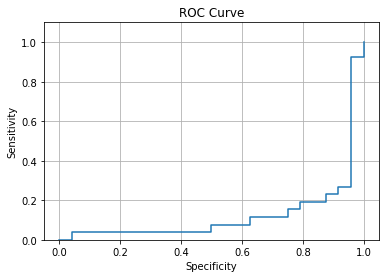

In [30]:
plot_roc(y_test,y_score)

In [0]:
import pickle
pickle.dump(best_clf, open("best_clf_distilbert", 'wb'))
